
Test ukko model using LONGITUDONAL FEATIRES. 

Create a time-dependent survival dataset that combines log-logistic survival times with sinusoidal features.  
OPtions:

- [x] amplitude modulation
- [ ] frequency modulation 


  ## Amplitude modulation

This approach creates an interpretable relationship between survival times and feature patterns, where:

- Longer survival times result in higher amplitude in the first feature
- The temporal patterns in the features could be used to predict survival
- The censoring mechanism affects both the survival times and the feature patterns

SurvivalSineWaveDataset:

- Use generate_survival_data_LL() for survival times and censoring
- Keep both dynamic (sinusoidal) and static features from the survival data
- Use normalized observed times for amplitude modulation of first feature
- Use static features to modulate amplitudes of other features

plot_survival_features to show:
- First feature (amplitude modulated by survival time)
- Other dynamic features (modulated by static features)
- Original static features from generate_survival_data_LL
- Added example usage and visualization:

In [1]:
# Set environment variable to handle OpenMP runtime conflict
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Also set this for the current session
if os.name == 'nt':  # Windows
    try:
        import ctypes
        ctypes.CDLL('mkl_rt.dll')
    except:
        pass


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Import required libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchsurv.loss.cox as tscox

# Import ukko functions
from ukko.survival import generate_survival_data_LL, plot_KM


In [3]:

class SurvivalSineWaveDataset(Dataset):
    def __init__(self, n_samples, n_features, sequence_length, 
                 shape=5, scale=10.0, censoring=0.3,
                 base_freq=0.1, noise_level=0.1, seed=42,
                 nonlinear=False):
        """
        Creates survival dataset with sinusoidal time-dependent features.
        The true survival time modulates the amplitude of the first feature.
        Uses generate_survival_data_LL for survival times generation.
        
        Args:
            n_samples: Number of samples
            n_features: Number of features for sinusoidal patterns (actual will be n_features + original features)
            sequence_length: Length of time series
            shape: Shape parameter for log-logistic distribution
            scale: Scale parameter for log-logistic distribution
            censoring: Censoring rate
            base_freq: Base frequency of sine waves
            noise_level: Standard deviation of Gaussian noise
        """
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        self.sequence_length = sequence_length
        self.n_features = n_features
        self.true_coefficients = np.random.uniform(0.5, 2.0, n_features) #placeholder for true coefficients
        
        # Generate survival data using ukko function
        survival_data, true_coefficients = generate_survival_data_LL(
            n_samples=n_samples,
            n_features=n_features,  # These will be our static features
            n_informative_features=1, #min(3, n_features),
            loglogistic_shape=shape,
            loglogistic_scale=scale,
            target_censoring_percentage=censoring
        )
        self.true_coefficients = true_coefficients

        # Extract survival information
        observed_times = survival_data['observed_time'].values
        events = survival_data['event_observed'].values
        static_features = survival_data[[f'feature_{i}' for i in range(n_features)]].values
        
        # Normalize survival times to use as amplitude modulation
        max_time = np.max(observed_times)
        normalized_times = observed_times / max_time
        
        # Plot normalized survival times
        plt.figure(figsize=(10, 6))
        plt.hist(normalized_times, bins=30, alpha=0.7, color='blue', edgecolor='black')
        plt.title('Histogram of Normalized Survival Times')
        print("Mean of normalized times:", np.mean(normalized_times))

        # Create time points for sequences
        t = np.linspace(0, sequence_length * 2 * np.pi, sequence_length)
        
        # Generate base frequencies and phases
        freq_array = np.random.uniform(0.5, 2.0, n_features)
        phase_array = np.random.uniform(0, 2 * np.pi, n_features)
        
        # Generate data for each sample
        data = []
        ampl = []
        for i in range(n_samples):
            sample = []
            for f in range(n_features):
                if f == 0:
                    # Modulate amplitude with survival time
                    amplitude = normalized_times[i]
                    if nonlinear:
                      # Define Gaussian function:
                      def gaussian(x, a=1, b=1, c=1):
                          """
                          Gaussian function with parameters a (peak height), b (possition), and c (width).
                          """
                          return a * np.exp( - (x - b) ** 2 / (2 * c ** 2))
                      def nonlinearity(x):
                          return gaussian(x, a=1, b=0.25, c=0.15)
                      # Apply Gaussian function to amplitude
                      amplitude = nonlinearity(normalized_times[i])
                      #print(f"nomalized_times[i]: {normalized_times[i]}, amplitude: {amplitude}")
                    amplitude0 = amplitude
                else:
                    # Use static features as base amplitudes
                    amplitude = (static_features[i, f] + 1) / 2  # Normalize to 0-1 range
                    #amplitude0 = []
                
                # Generate sine wave with noise
                sine_wave = amplitude * np.sin(freq_array[f] * base_freq * t + phase_array[f])
                noise = np.random.normal(0, noise_level, len(t))
                feature_data = sine_wave + noise
                
                sample.append(feature_data)
            data.append(sample)
            ampl.append(amplitude0)
        
        # Convert to torch tensors
        self.data = torch.FloatTensor(data)  # [n_samples, n_features, sequence_length]
        self.static_features = torch.FloatTensor(static_features)  # Keep original features
        self.amplitude = torch.FloatTensor(ampl)  # Store amplitude for first feature
        self.observed_times = torch.FloatTensor(observed_times)
        self.events = torch.FloatTensor(events)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx]
        static = self.static_features[idx]
        time = self.observed_times[idx]
        event = self.events[idx]
        return x, static, time, event
        

In [4]:
def plot_survival_features(dataset, sample_indices=None):
    """Plot survival times and corresponding feature patterns."""
    
    # deal with fact that dataset might be smaller than 4 samples
    if len(dataset) < 4:
        nsamples = len(dataset)
    else:
        nsamples = 4

    # Take samples
    if sample_indices is None:
        sample_indices = np.random.choice(len(dataset), nsamples, replace=False)
        
    fig, axes = plt.subplots(len(sample_indices), 3, figsize=(15, 3*len(sample_indices)))
    
    for i, idx in enumerate(sample_indices):
        x, static, time, event = dataset[idx]
        
        # Plot first feature (amplitude modulated by survival)
        axes[i,0].plot(x[0].numpy())
        axes[i,0].set_title(f'Sample {idx}: Time={time:.1f}, Event={event:.0f}')
        axes[i,0].set_ylabel('Feature 1 (Survival)')
        axes[i,0].grid(True)
        
        # Plot other dynamic features
        for j in range(1, dataset.n_features):
            axes[i,1].plot(x[j].numpy(), label=f'Feature {j+1}')
        axes[i,1].set_title('Other Dynamic Features')
        axes[i,1].grid(True)
        if i == 0:
            axes[i,1].legend()
        
        # Plot static features
        axes[i,2].bar(range(len(static)), static.numpy())
        axes[i,2].set_title('Static Features')
        axes[i,2].set_ylim(-2, 2)
        axes[i,2].grid(True)
            
    plt.tight_layout()

    
    fig2, ax = plt.subplots(1,2,figsize=(10, 3) )
    # plot amplitude of featuer 1 against survival time
    # Note: toch.max retunrs a tuple (values, indices), we need to take values
    ax[0].scatter(dataset.observed_times.numpy(), dataset.data[:, 0, :].max(dim=1)[0].numpy(), alpha=0.1)
    ax[0].set_xlabel('Observed Survival Time')
    ax[0].set_ylabel('Mean Amplitude of Feature 1')
    ax[0].set_title('Amplitude of Feature 1 vs Survival Time')
    # plot first static_feature agains tsurvival time
    ax[1].scatter(dataset.observed_times.numpy(), dataset.static_features[:, 0].numpy(), alpha=0.1)
    ax[1].set_xlabel('Observed Survival Time')
    ax[1].set_ylabel('First Static Feature')
    ax[1].set_title('First Static Feature vs Survival Time') 
    
    return fig, fig2

Mean of normalized times: 0.24411428219671935


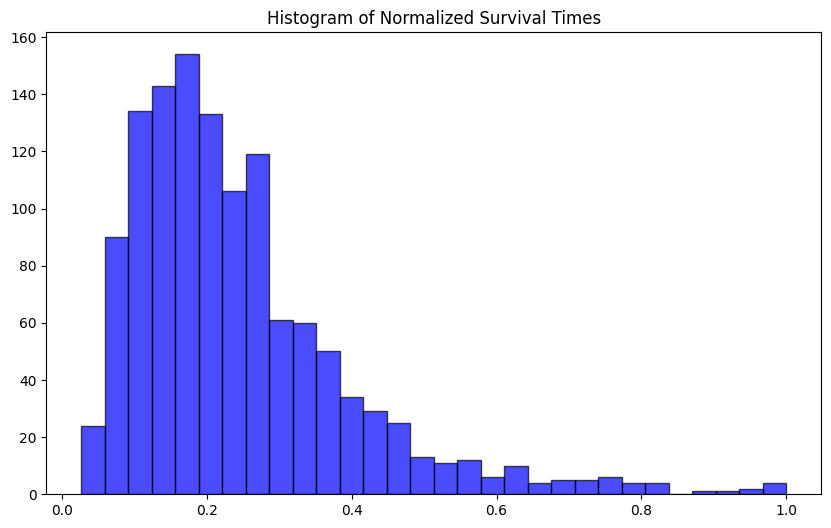

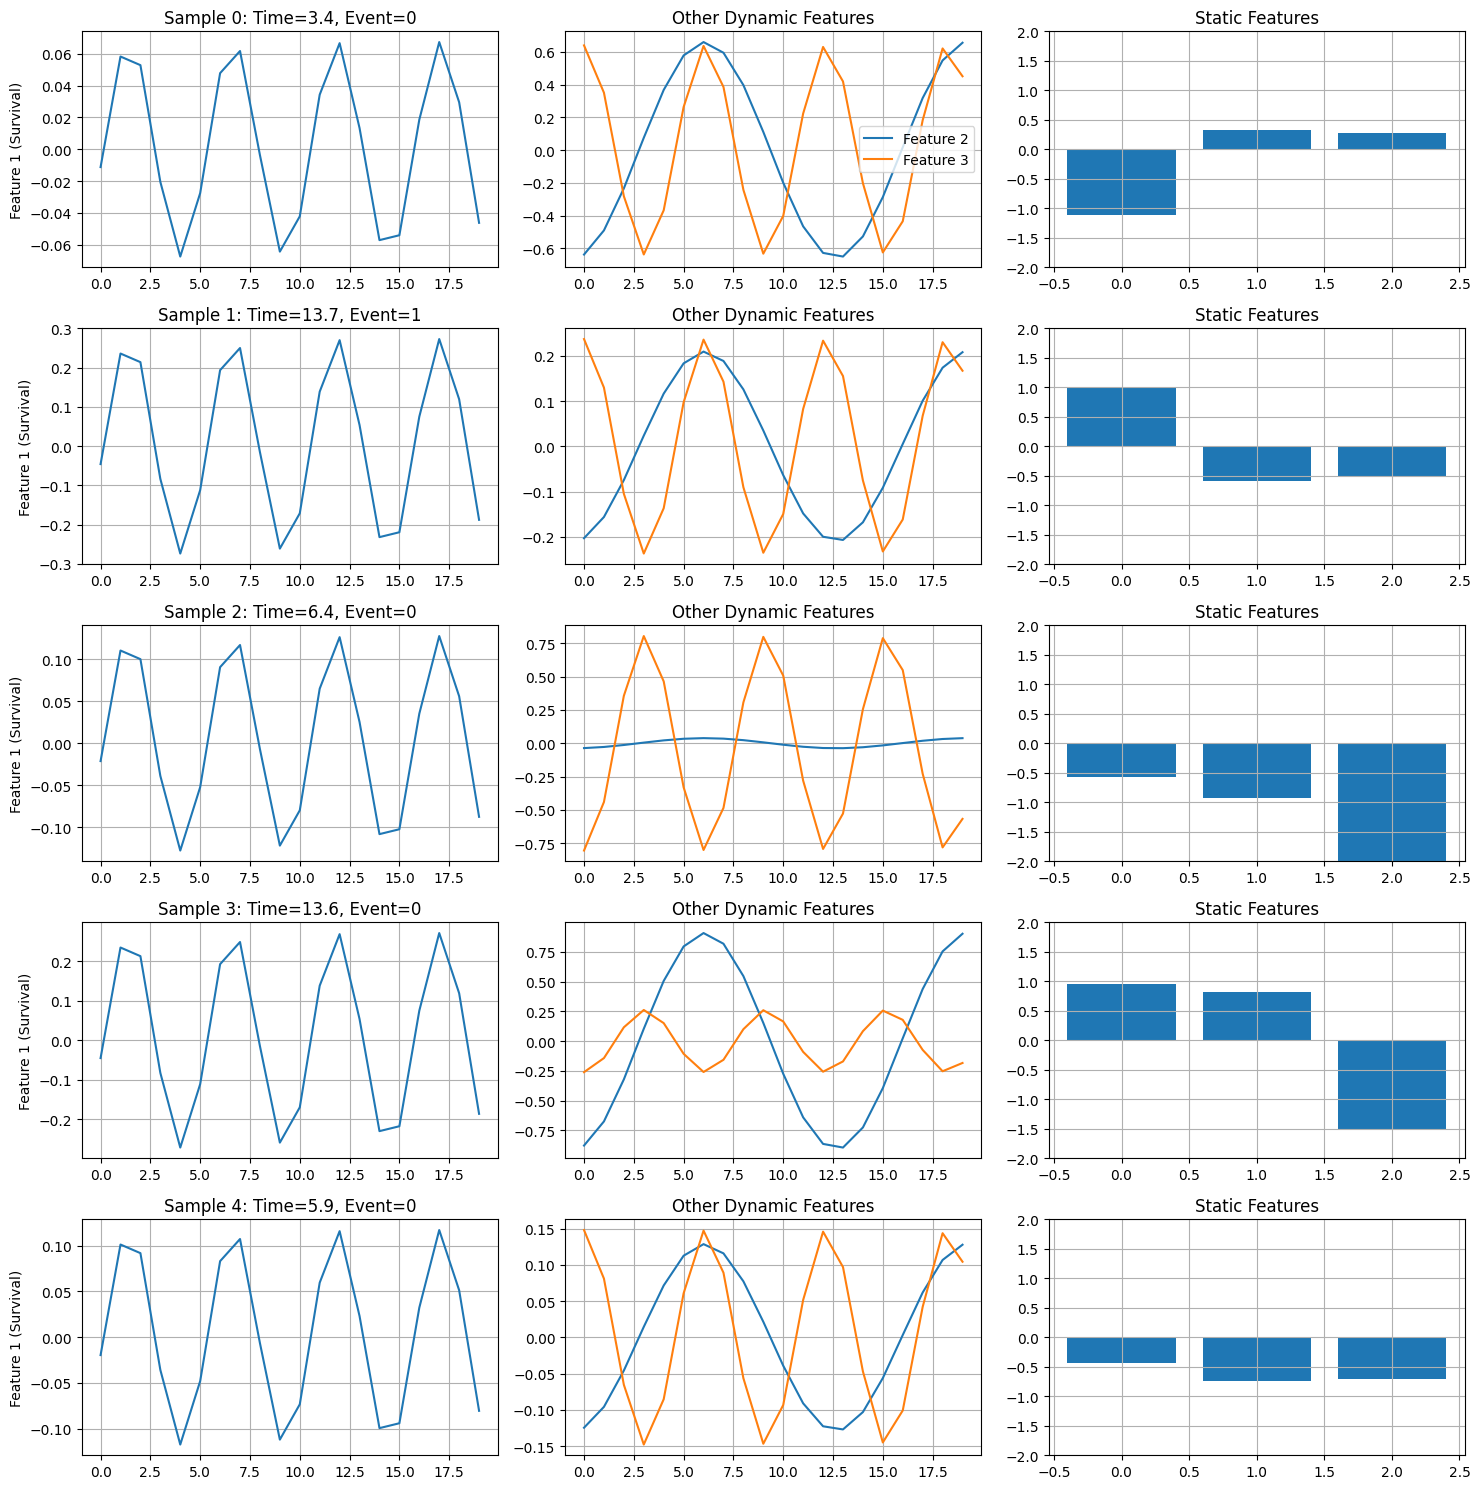

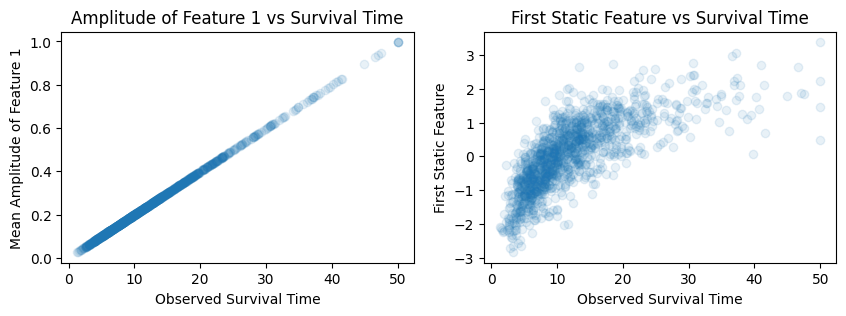

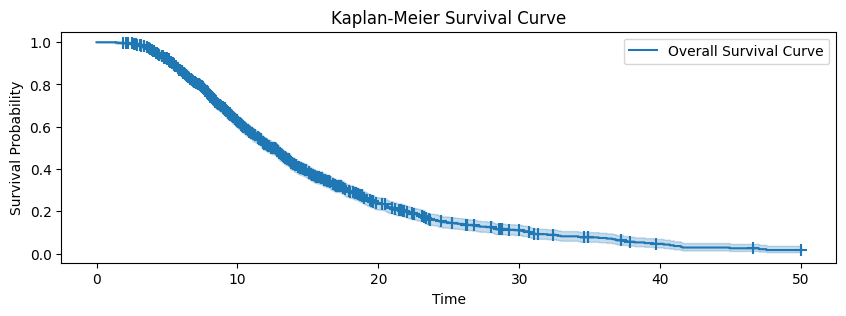

In [8]:
# Linear sine wave dataset with survival times
dataset_lin = SurvivalSineWaveDataset(
    n_samples=1250,
    n_features=3,
    sequence_length=20,
    shape=5,
    scale=10.0,
    censoring=0.3,
    noise_level=0.0,
    nonlinear=False
)

# Plot examples
fig = plot_survival_features(dataset_lin, sample_indices=[0, 1, 2, 3, 4])
plt.show()

# Plot KM curve for the dataset
survival_df_lin = pd.DataFrame({
    'observed_time': dataset_lin.observed_times.numpy(),
    'event_observed': dataset_lin.events.numpy()
})
plot_KM(survival_df_lin)

Mean of normalized times: 0.24411428219671935


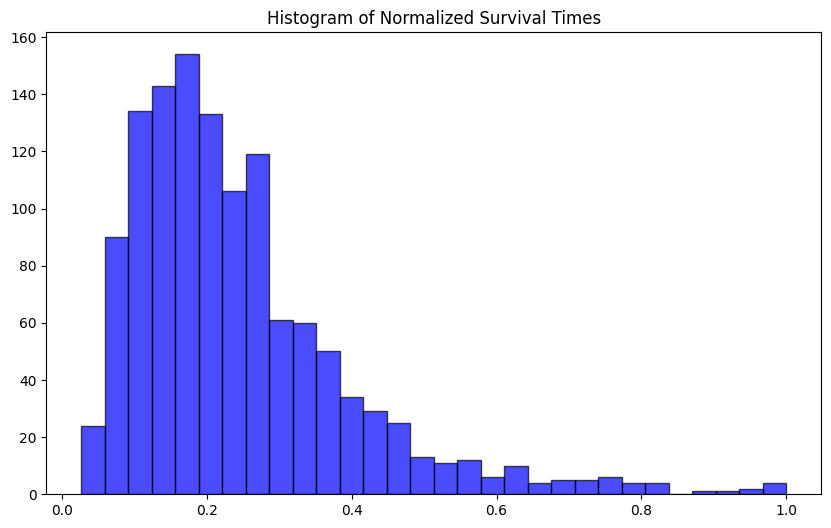

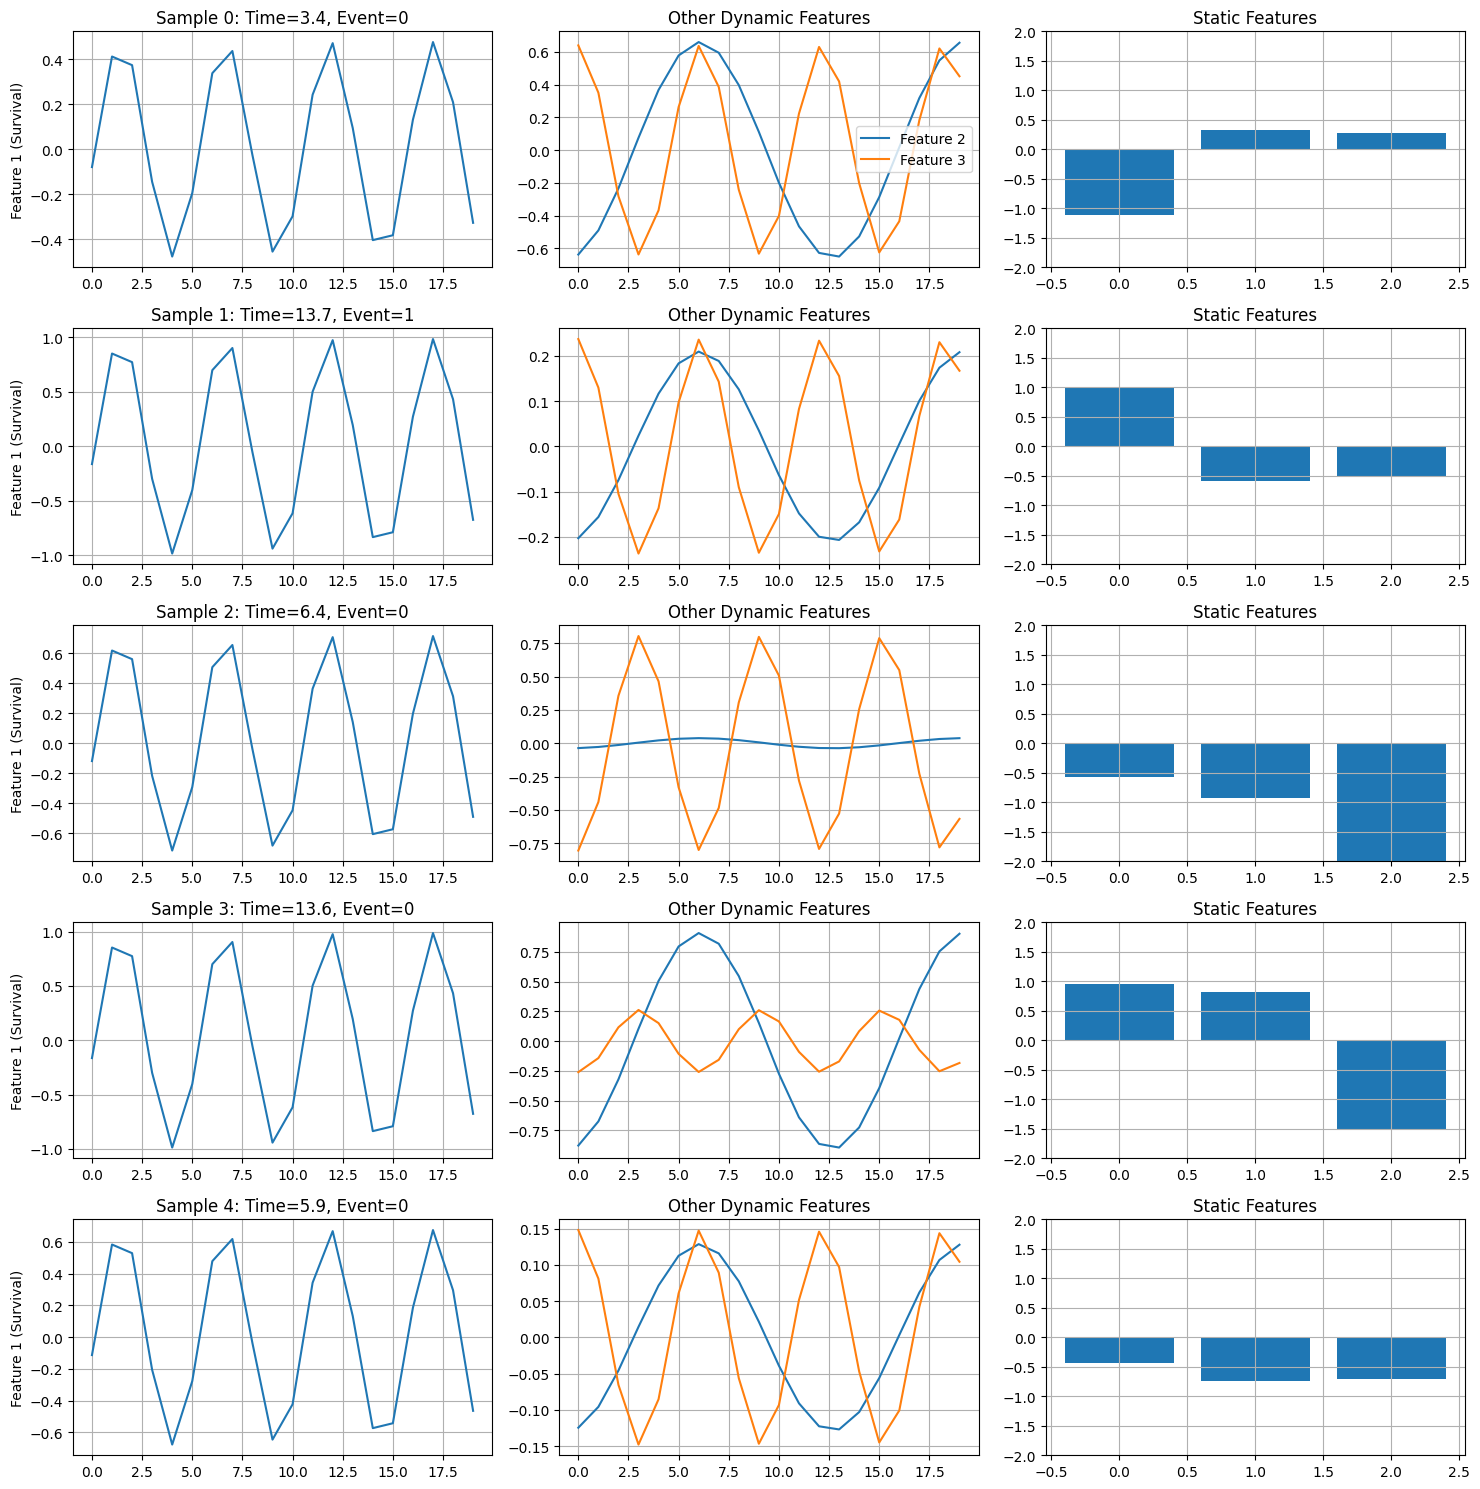

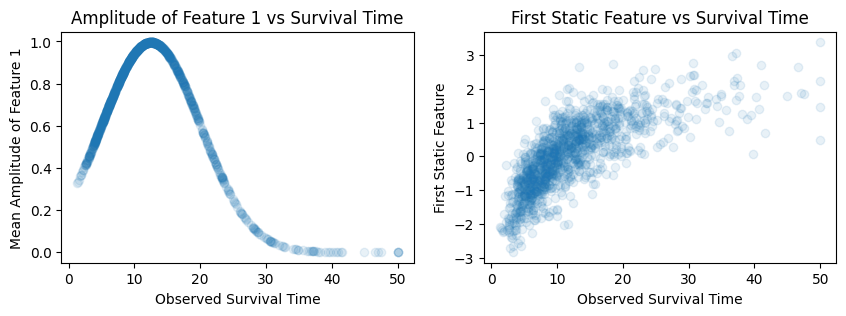

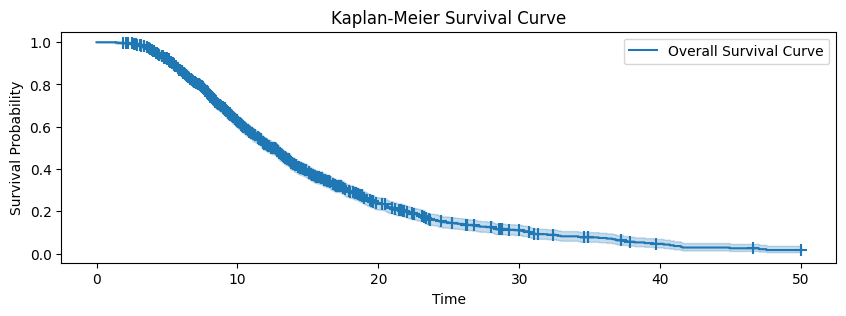

In [9]:
# Nonliear sine wave dataset with survival times
dataset = SurvivalSineWaveDataset(
    n_samples=1250,
    n_features=3,
    sequence_length=20,
    shape=5,
    scale=10.0,
    censoring=0.3,
    noise_level=0.0,
    nonlinear=True
)

#print(dataset)

# Plot examples
fig = plot_survival_features(dataset, sample_indices=[0, 1, 2, 3, 4])
plt.show()

# Plot KM curve for the dataset
survival_df = pd.DataFrame({
    'observed_time': dataset.observed_times.numpy(),
    'event_observed': dataset.events.numpy()
})
plot_KM(survival_df)

In [18]:
dataset.data
dataset.static_features


tensor([[ 0.4967, -0.1383,  0.6477,  1.5230, -0.2342],
        [-0.2341,  1.5792,  0.7674, -0.4695,  0.5426],
        [-0.4634, -0.4657,  0.2420, -1.9133, -1.7249],
        ...,
        [ 1.6358, -0.2210,  0.0694,  0.1926,  2.3921],
        [-2.0994,  0.6832, -0.1148,  0.5668, -0.6574],
        [-0.0490,  0.7114,  3.1129,  0.8080, -0.8481]])

## 2. Survival Analysis with ukko Model

Now we'll implement a survival analysis using the ukko dual attention architecture. The key components are:

1. UkkoSurvivalModel class that combines the dual attention network with a survival head
2. Training loop with Cox partial likelihood loss
3. Risk stratification and visualization

In [10]:
from ukko.core import DualAttentionRegressor1
import copy
from torch.utils.data import DataLoader, TensorDataset
import torchsurv.loss.cox as tscox

# Define the Ukko Survival model
class UkkoSurvivalModel(nn.Module):
    def __init__(self, sequence_length, n_features, 
                 d_model=64, n_heads=4, dropout=0.1, n_modules=3):
        super().__init__()
        self.attention_net = DualAttentionRegressor1(
            n_features=n_features,
            time_steps=sequence_length,
            d_model=d_model, #128,
            n_heads=n_heads,
            dropout=dropout,
            n_modules=n_modules
        )
    
    def forward(self, x):
        # Get predictions from attention network
        predictions, feat_weights, time_weights = self.attention_net(x)
        return predictions, feat_weights, time_weights

# DEPRECIATED: Generating a dataloader using TensorDataset:
#              Instead use `SurvivalSineWaveDataset` directly with DataLoader
# # Prepare data for training
# X = torch.FloatTensor(dataset.data.numpy())
# times = torch.FloatTensor(dataset.observed_times.numpy())
# events = torch.FloatTensor(dataset.events.numpy())
# # Create data loader
# survival_dataset = TensorDataset(X, times, events)
# batch_size = 32
# train_loader = DataLoader(survival_dataset, batch_size=batch_size, shuffle=True)

batch_size =  dataset.__len__()
print(f"Batch size: {batch_size}")
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Batch size: 1250


In [18]:
def train_model(model, train_loader, val_loader, optimizer, n_epochs=30, device='cuda', patience=5):
    """
    Train the survival model with validation monitoring.
    
    Args:
        model: PyTorch model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        optimizer: PyTorch optimizer
        n_epochs: Number of training epochs
        device: Device to train on ('cuda' or 'cpu')
        patience: Number of epochs to wait for improvement before early stopping
    
    Returns:
        model: Trained model (best version)
        history: Dict containing training and validation losses
        best_val_loss: Best validation loss achieved
    """
    # Setup device
    device = torch.device(device if torch.cuda.is_available() and device=='cuda' else 'cpu')
    model = model.to(device)
    print(f'Training on {device}')

    if torch.cuda.is_available():
      print(f'GPU: {torch.cuda.get_device_name(0)}')
    
    # Initialize tracking variables
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    def evaluate(model, data_loader):
        """Evaluate model on given data loader"""
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for X_batch, static, times_batch, events_batch in data_loader:
                X_batch = X_batch.to(device)
                times_batch = times_batch.to(device)
                events_batch = events_batch.to(device)
                
                log_hazards, _, _ = model(X_batch)
                loss = tscox.neg_partial_log_likelihood(
                    log_hazards, events_batch==1, times_batch, 
                    ties_method='efron', reduction='mean'
                )
                total_loss += loss.item()
        return total_loss / len(data_loader)
    
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss = 0
        
        for X_batch, static, times_batch, events_batch in train_loader:
            X_batch = X_batch.to(device)
            times_batch = times_batch.to(device)
            events_batch = events_batch.to(device)
            
            optimizer.zero_grad()
            log_hazards, feat_weights, time_weights = model(X_batch)
            
            loss = tscox.neg_partial_log_likelihood(
                log_hazards, events_batch==1, times_batch, 
                ties_method='efron', reduction='mean'
            )
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Calculate average losses
        train_loss = train_loss / len(train_loader)
        val_loss = evaluate(model, val_loader)
        
        # Store losses
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{n_epochs} Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} Best Val Loss: {best_val_loss:.4f}')
        
        # Early stopping
        if patience_counter >= patience:
            print(f'\nEarly stopping after {epoch + 1} epochs')
            break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return model, history, best_val_loss


Total samples: 1250, Train size: 1000, Val size: 250
Batch size: 1000
Training on cuda
GPU: Tesla V100-SXM2-32GB


/users/ericfey1/.local/lib/python3.11/site-packages/torchsurv/loss/cox.py:138: UserWarning: Ties in event time detected; using efron's method to handle ties.
  warnings.warn(


Epoch 20/6000 Train Loss: 5.9504 Val Loss: 4.5313 Best Val Loss: 4.5123
Epoch 40/6000 Train Loss: 5.9472 Val Loss: 4.5249 Best Val Loss: 4.5123
Epoch 60/6000 Train Loss: 5.8988 Val Loss: 4.4919 Best Val Loss: 4.4919
Epoch 80/6000 Train Loss: 5.8807 Val Loss: 4.4422 Best Val Loss: 4.4397
Epoch 100/6000 Train Loss: 5.8068 Val Loss: 4.3879 Best Val Loss: 4.3832
Epoch 120/6000 Train Loss: 5.7994 Val Loss: 4.3165 Best Val Loss: 4.3052
Epoch 140/6000 Train Loss: 5.6887 Val Loss: 4.2434 Best Val Loss: 4.2434
Epoch 160/6000 Train Loss: 5.6482 Val Loss: 4.2300 Best Val Loss: 4.2300
Epoch 180/6000 Train Loss: 5.6184 Val Loss: 4.2311 Best Val Loss: 4.2210
Epoch 200/6000 Train Loss: 5.5888 Val Loss: 4.3307 Best Val Loss: 4.2210
Epoch 220/6000 Train Loss: 5.5657 Val Loss: 4.2446 Best Val Loss: 4.2210
Epoch 240/6000 Train Loss: 5.6095 Val Loss: 4.2495 Best Val Loss: 4.2210
Epoch 260/6000 Train Loss: 5.5493 Val Loss: 4.1981 Best Val Loss: 4.1981
Epoch 280/6000 Train Loss: 5.5389 Val Loss: 4.2782 Best

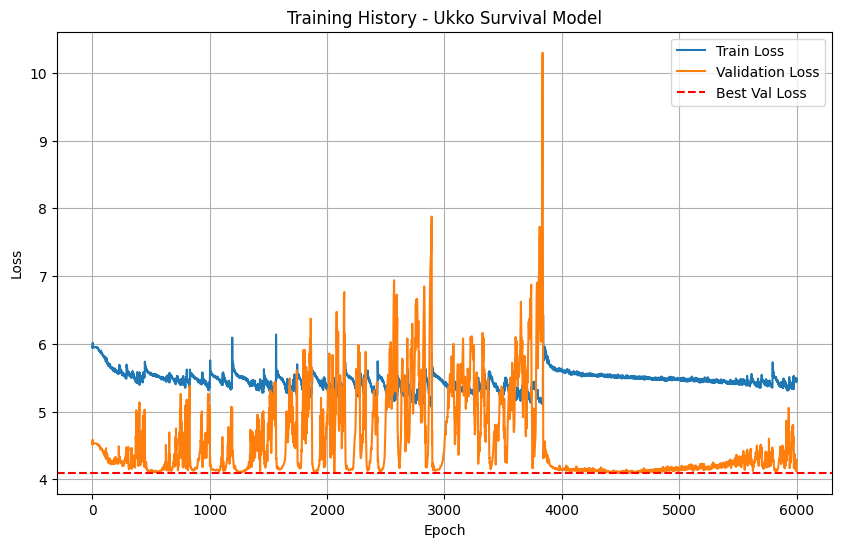

In [19]:
# Pred data loader:

# Create train/val split
from torch.utils.data import random_split

# Calculate split sizes
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
print(f"Total samples: {total_size}, Train size: {train_size}, Val size: {val_size}")

# Create splits
train_dataset, val_dataset = random_split(
    dataset, #survival_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Create data loaders
batch_size = train_dataset.__len__() #64
print(f"Batch size: {batch_size}")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize model and optimizer
model = UkkoSurvivalModel(sequence_length=dataset.sequence_length, n_features=dataset.n_features, 
                          d_model=64, n_heads=4, dropout=0.1, n_modules=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train model
model, history, best_val_loss = train_model(
    model, train_loader, val_loader, optimizer,
    n_epochs=6000,
    patience=6000
)

# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.axhline(y=best_val_loss, color='r', linestyle='--', label='Best Val Loss')
plt.title('Training History - Ukko Survival Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

X.shape: torch.Size([1000, 3, 20])
Lowest Risk (Q1) size: 200
Q2 size: 200
Q3 size: 200
Q4 size: 200
Highest Risk (Q5) size: 200
X.shape: torch.Size([250, 3, 20])
Lowest Risk (Q1) size: 50
Q2 size: 50
Q3 size: 50
Q4 size: 50
Highest Risk (Q5) size: 50


Text(0.5, 1.0, 'Kaplan-Meier Curves by Risk Group - Validation Set')

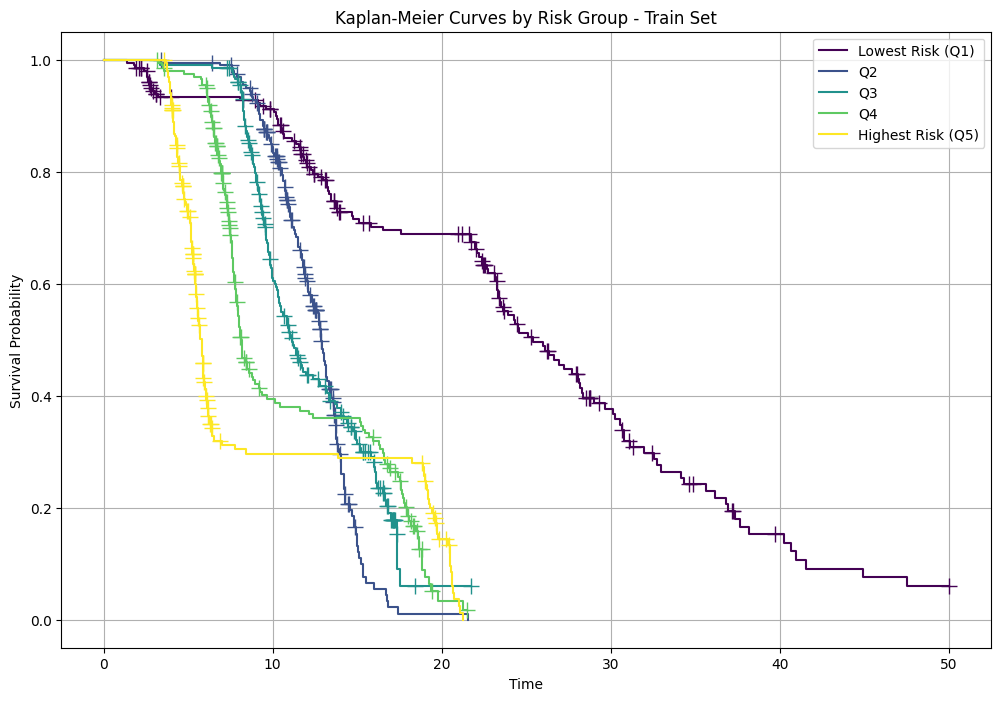

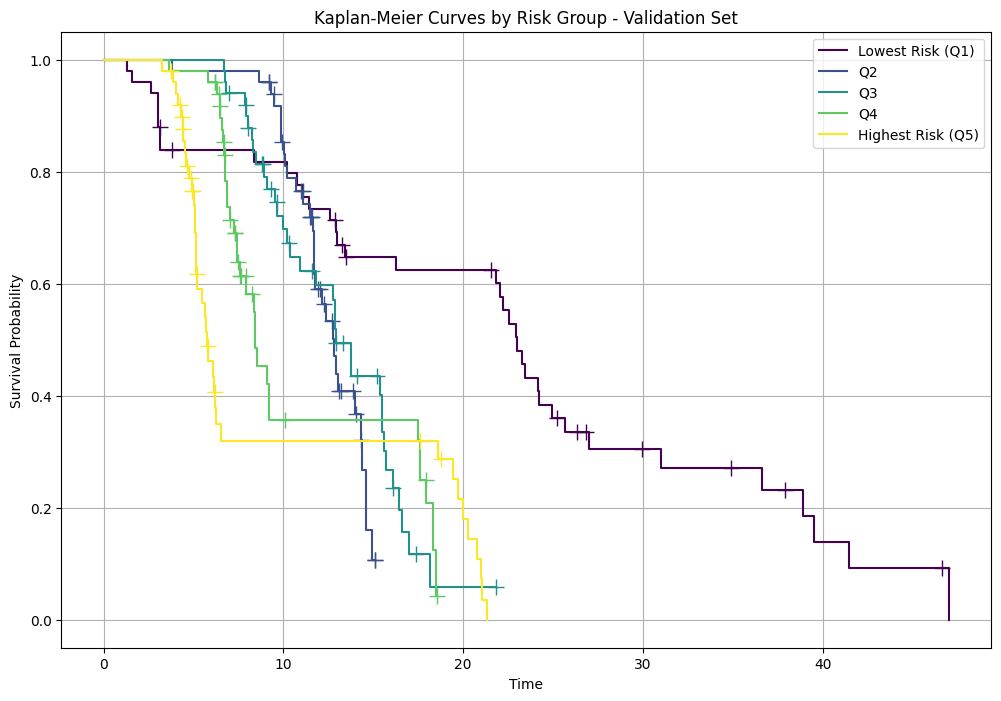

In [20]:
def stratify_and_plot(survival_data, risk_scores, n_groups=4):
    """Stratify patients into multiple risk groups and plot KM curves."""
    survival_data = survival_data.copy()
    survival_data['predicted_risk'] = risk_scores
    
    # Calculate quantile cutoffs
    quantiles = np.linspace(0, 1, n_groups + 1)
    cutoffs = np.quantile(survival_data['predicted_risk'], quantiles)
    
    # Plot KM curves
    fig = plt.figure(figsize=(12, 8))
    
    # Create color map for groups
    colors = plt.cm.viridis(np.linspace(0, 1, n_groups))
    
    for i in range(n_groups):
        if i == 0:
            mask = survival_data['predicted_risk'] <= cutoffs[1]
            group_label = f'Lowest Risk (Q1)'
        elif i == n_groups - 1:
            mask = survival_data['predicted_risk'] > cutoffs[-2]
            group_label = f'Highest Risk (Q{n_groups})'
        else:
            mask = (survival_data['predicted_risk'] > cutoffs[i]) & \
                   (survival_data['predicted_risk'] <= cutoffs[i+1])
            group_label = f'Q{i+1}'
        
        group = survival_data[mask]
        
        kmf = KaplanMeierFitter()
        kmf.fit(durations=group['observed_time'],
                event_observed=group['event_observed'],
                label=group_label)
        kmf.plot_survival_function(show_censors=True, ci_show=False, color=colors[i])
        
        print(f"{group_label} size: {len(group)}")
    
    plt.title('Kaplan-Meier Survival Curves by Risk Group')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.grid(True)
    plt.legend()
    #plt.show()
    
    return fig, cutoffs

# Model performance evaluation:
# For TensorDataset use .tesnsors, for SurvivalSineWaveDataset use .data
# X =  train_loader.dataset.tensors[0].cpu() 
indices = train_loader.dataset.indices
X = train_loader.dataset.dataset.data[indices].data.cpu()  # get features of training set
print(f"X.shape: {X.shape}")
#.data.cpu()

# Generate risk scores using the trained model
model.eval().to('cpu')
with torch.no_grad():
    risk_scores, feat_weights, time_weights = model(X)
    risk_scores = risk_scores.numpy()

# Create stratification plot
sur_df = pd.DataFrame({
    'observed_time': dataset.observed_times[indices].numpy(),
    'event_observed': dataset.events[indices].numpy()
})
fig, cutoffs = stratify_and_plot(sur_df, risk_scores, n_groups=5)
fig.gca().set_title('Kaplan-Meier Curves by Risk Group - Train Set')

# Val set:
indices = val_loader.dataset.indices
X = val_loader.dataset.dataset.data[indices].data.cpu()  # get features of training set
print(f"X.shape: {X.shape}")
#.data.cpu()

# Generate risk scores using the trained model
model.eval().to('cpu')
with torch.no_grad():
    risk_scores, feat_weights, time_weights = model(X)
    risk_scores = risk_scores.numpy()

# Create stratification plot
sur_df = pd.DataFrame({
    'observed_time': dataset.observed_times[indices].numpy(),
    'event_observed': dataset.events[indices].numpy()
})
fig, cutoffs = stratify_and_plot(sur_df, risk_scores, n_groups=5)
fig.gca().set_title('Kaplan-Meier Curves by Risk Group - Validation Set')

# # Visualize attention weights
# plt.figure(figsize=(15, 5))

# # Feature attention weights - reshape for visualization
# feat_attention = feat_weights.detach().numpy()
# # print dim of feat_attention 
# print("Feature attention shape:", feat_attention.shape)  # Should be [batch_size, n_features, sequence_length]

# # Plot feature attention weights
# plt.subplot(1, 2, 1)
# plt.imshow(feat_attention.T)
# plt.title('Feature Attention Weights')
# plt.xlabel('Sample')
# plt.ylabel('Feature')
# plt.colorbar()

# # Time attention weights
# time_attention = time_weights.detach().numpy().mean(axis=0)  # Average across batch

# # Plot time attention weights
# plt.subplot(1, 2, 2)
# plt.plot(time_attention)
# plt.title('Time Attention Weights (Average)')
# plt.xlabel('Time Step')
# plt.ylabel('Weight')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

In [51]:
dataset.observed_times


tensor([ 5.5519, 25.4609, 11.3411, 13.9514, 10.4594,  5.2004, 18.5566, 12.6309,
        11.3167, 12.7856,  7.8277, 24.0614,  9.9963,  2.1165,  9.0375,  6.6737,
        12.4085, 13.9539, 16.7949,  7.3374,  7.2755, 13.3010, 33.4872,  8.4549,
        16.7344,  6.7601, 11.9696, 20.9601, 11.0898, 13.1245,  9.6446, 11.9915,
        11.4909,  6.5916,  8.7755,  4.4414,  5.3325, 11.3411, 12.6607,  4.0292,
         4.4630, 21.0018,  4.9086, 19.4345, 15.5571,  4.2300,  5.2989, 29.7049,
        15.7961,  8.2662, 22.8679, 29.3668, 25.1611, 21.5412,  6.6398, 10.4249,
         8.9907,  7.6343, 15.4564, 16.3637,  4.4437,  9.3964,  3.3989,  8.4741,
         7.6165, 13.8136, 10.3141, 17.5218, 17.9883, 11.8878, 34.4650, 13.5452,
         5.1868, 10.2666,  3.7409, 19.8577,  7.8747, 11.8841,  9.4180, 18.2576,
         8.5188, 50.0000,  6.8695, 17.5627, 11.5688,  6.0230, 11.0290, 11.3006,
        18.1677,  9.1683, 12.6411, 15.9526,  2.4959, 19.7170, 21.6193, 16.5520,
         7.4749, 20.0248,  6.3761,  5.57

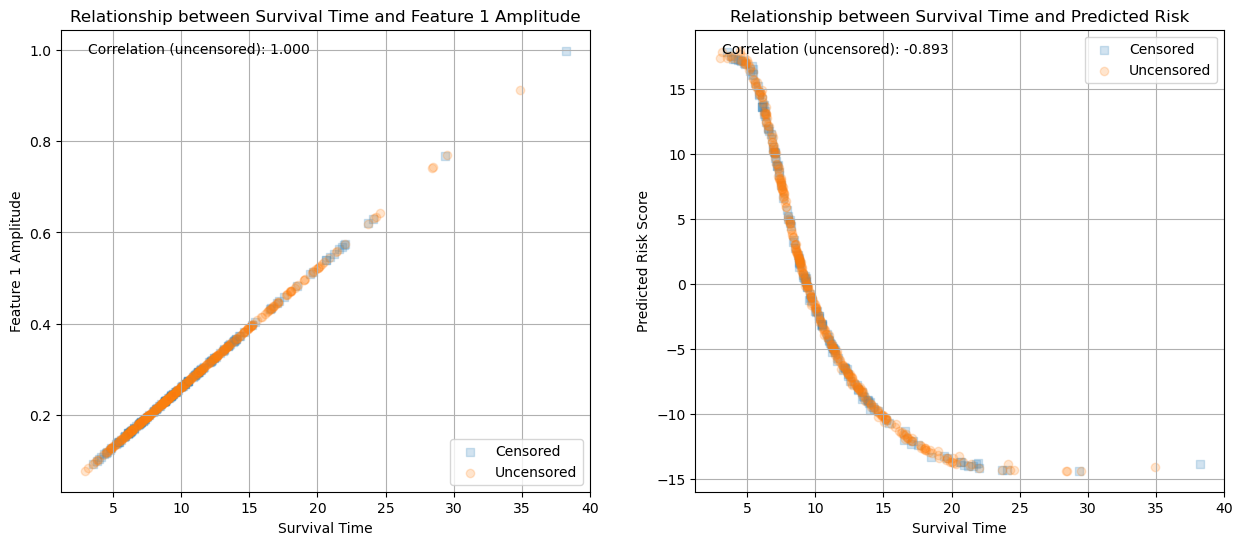

In [79]:
# Plot relationship between survival time and first feature amplitude
def plot_amplitude_survival_relationship(dataset,ax=None):
    """Plot scatter of survival times vs amplitude of first feature"""
    
    # Get amplitude of first feature for each sample (max absolute value)
    amplitudes = dataset.data[:, 0].abs().max(dim=1)[0]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot censored and uncensored separately
    censored = dataset.events == 0
    uncensored = dataset.events == 1
    
    ax.scatter(dataset.observed_times[censored], amplitudes[censored], 
                alpha=0.2, label='Censored', marker='s')
    ax.scatter(dataset.observed_times[uncensored], amplitudes[uncensored], 
             alpha=0.2, label='Uncensored', marker='o')
    ax.set_xlabel('Survival Time')
    ax.set_ylabel('Feature 1 Amplitude')
    ax.set_title('Relationship between Survival Time and Feature 1 Amplitude')
    ax.grid(True)
    ax.legend()
    
    # Add correlation coefficient for uncensored samples
    corr = np.corrcoef(dataset.observed_times[uncensored].numpy(), 
                       amplitudes[uncensored].numpy())[0,1]
    ax.text(0.05, 0.95, f'Correlation (uncensored): {corr:.3f}', 
             transform=ax.transAxes)


def plot_risk_survival_relationship(risk_scores, dataset, ax=None):
    """Plot scatter of survival times vs predicted risk scores"""
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot censored and uncensored separately
    censored = dataset.events == 0
    uncensored = dataset.events == 1
    
    # Convert risk scores to numpy if they're tensors
    if torch.is_tensor(risk_scores):
        risk_scores = risk_scores.numpy()
    
    # Flatten risk scores if needed
    if len(risk_scores.shape) > 1:
        risk_scores = risk_scores.flatten()
    
    ax.scatter(dataset.observed_times[censored], risk_scores[censored], 
               alpha=0.2, label='Censored', marker='s')
    ax.scatter(dataset.observed_times[uncensored], risk_scores[uncensored], 
               alpha=0.2, label='Uncensored', marker='o')
    
    ax.set_xlabel('Survival Time')
    ax.set_ylabel('Predicted Risk Score')
    ax.set_title('Relationship between Survival Time and Predicted Risk')
    ax.grid(True)
    ax.legend()
    
    # Add correlation coefficient for uncensored samples
    corr = np.corrcoef(dataset.observed_times[uncensored].numpy(), 
                       risk_scores[uncensored])[0,1]
    ax.text(0.05, 0.95, f'Correlation (uncensored): {corr:.3f}', 
            transform=ax.transAxes)
    

# Get risk scores from the trained model
#model.eval()
#with torch.no_grad():
#    risk_scores, _, _ = model(X)

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
#
plot_amplitude_survival_relationship(dataset, ax=ax1)
#  assumes that model has been evaluated and risk_scores are available
plot_risk_survival_relationship(risk_scores, dataset, ax=ax2)


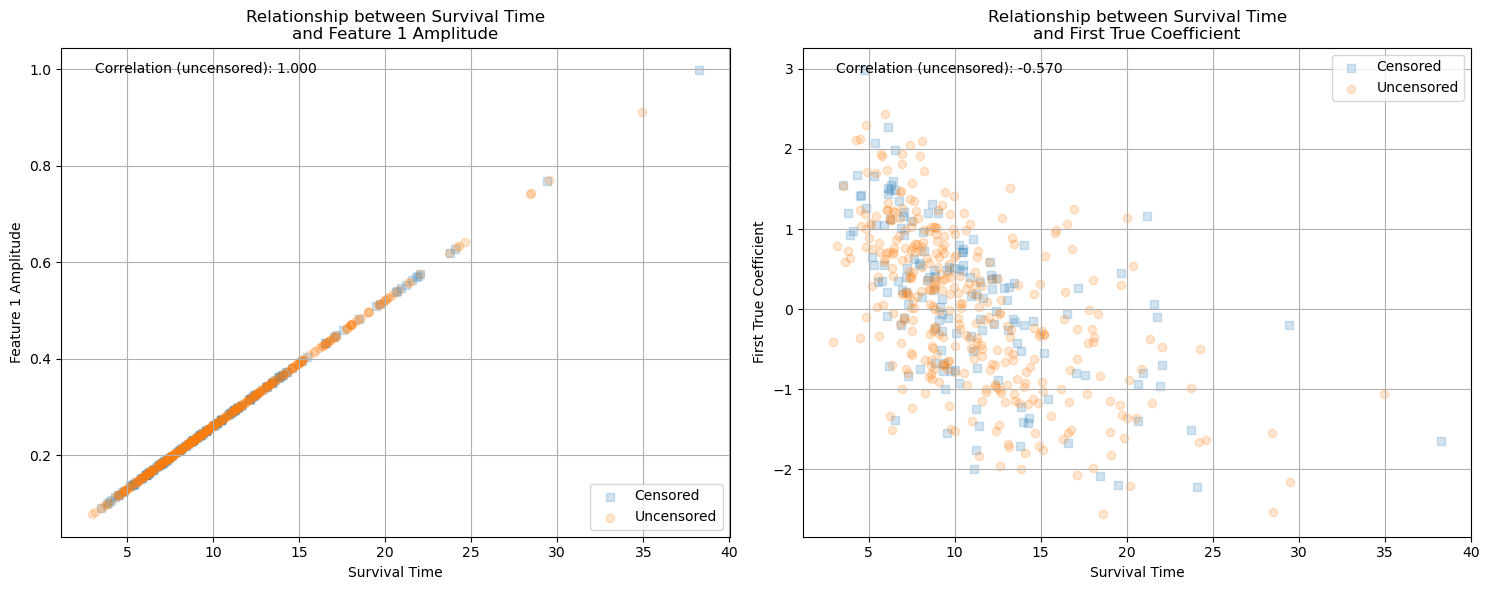

In [81]:
# Plot relationship between survival time and first feature amplitude
def plot_amplitude_survival_relationship(dataset):
    """Plot scatter of survival times vs amplitude of first feature and true coefficients"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # First subplot - Amplitude relationship
    # Get amplitude of first feature for each sample (max absolute value)
    amplitudes = dataset.data[:, 0].abs().max(dim=1)[0]
    
    # Plot censored and uncensored separately
    censored = dataset.events == 0
    uncensored = dataset.events == 1
    
    ax1.scatter(dataset.observed_times[censored], amplitudes[censored], 
                alpha=0.2, label='Censored', marker='s')
    ax1.scatter(dataset.observed_times[uncensored], amplitudes[uncensored], 
                alpha=0.2, label='Uncensored', marker='o')
    
    ax1.set_xlabel('Survival Time')
    ax1.set_ylabel('Feature 1 Amplitude')
    ax1.set_title('Relationship between Survival Time\nand Feature 1 Amplitude')
    ax1.grid(True)
    ax1.legend()
    
    # Add correlation coefficient for uncensored samples
    corr = np.corrcoef(dataset.observed_times[uncensored].numpy(), 
                       amplitudes[uncensored].numpy())[0,1]
    ax1.text(0.05, 0.95, f'Correlation (uncensored): {corr:.3f}', 
             transform=ax1.transAxes)
    
    # Second subplot - True coefficients relationship
    first_coef = dataset.static_features[:, 0]  # Get first static feature
    
    ax2.scatter(dataset.observed_times[censored], first_coef[censored], 
                alpha=0.2, label='Censored', marker='s')
    ax2.scatter(dataset.observed_times[uncensored], first_coef[uncensored], 
                alpha=0.2, label='Uncensored', marker='o')
    
    ax2.set_xlabel('Survival Time')
    ax2.set_ylabel('First True Coefficient')
    ax2.set_title('Relationship between Survival Time\nand First True Coefficient')
    ax2.grid(True)
    ax2.legend()
    
    # Add correlation coefficient for uncensored samples
    corr = np.corrcoef(dataset.observed_times[uncensored].numpy(), 
                       first_coef[uncensored].numpy())[0,1]
    ax2.text(0.05, 0.95, f'Correlation (uncensored): {corr:.3f}', 
             transform=ax2.transAxes)
    
    plt.tight_layout()
    plt.show()

# Create the plot
plot_amplitude_survival_relationship(dataset)

### Hyperparameter search

In [ ]:
#Helper functions:

def inspect_dataloader(loader):
    """Inspect a DataLoader's contents and structure"""
    
    # Get basic info
    print("DataLoader Info:")
    print(f"Number of batches: {len(loader)}")
    print(f"Batch size: {loader.batch_size}")
    print(f"Dataset size: {len(loader.dataset)}")
    
    # Get first batch
    print("\nFirst batch contents:")
    batch = next(iter(loader))
    print(f"Number of items in batch: {len(batch)}")
    
    # Print each tensor's shape and type
    for i, tensor in enumerate(batch):
        print(f"\nItem {i}:")
        print(f"Shape: {tensor.shape}")
        print(f"Type: {tensor.dtype}")
        print(f"First element:\n{tensor[0]}")

# Test the loader
#train_loader, val_loader = search._get_dataloaders(64)
#inspect_dataloader(train_loader)

In [ ]:
# # Create search instance
# search = HyperparameterSearch(dataset)
# train_loader, val_loader = search._get_dataloaders(64)
# inspect_dataloader(train_loader)


DataLoader Info:
Number of batches: 7
Batch size: 64
Dataset size: 400

First batch contents:
Number of items in batch: 4

Item 0:
Shape: torch.Size([64, 3, 20])
Type: torch.float32
First element:
tensor([[ 0.1584, -0.0109, -0.1684, -0.1421,  0.0392,  0.1777,  0.1224, -0.0665,
         -0.1828, -0.0997,  0.0922,  0.1835,  0.0746, -0.1157, -0.1798, -0.0477,
          0.1364,  0.1717,  0.0197, -0.1538],
        [-0.4763,  0.1063,  0.6148,  0.6949,  0.2907, -0.3160, -0.7026, -0.5995,
         -0.0786,  0.4970,  0.7263,  0.4494, -0.1406, -0.6327, -0.6838, -0.2584,
          0.3471,  0.7107,  0.5791,  0.0439],
        [-0.5739, -0.1401,  0.4133,  0.6141,  0.2912, -0.2801, -0.6125, -0.4224,
          0.1280,  0.5692,  0.5249,  0.0329, -0.4872, -0.5917, -0.1916,  0.3720,
          0.6183,  0.3372, -0.2315, -0.6027]])

Item 1:
Shape: torch.Size([64, 3])
Type: torch.float32
First element:
tensor([0.9207, 0.4539, 0.2372])

Item 2:
Shape: torch.Size([64])
Type: torch.float32
First element:
7.0272

In [ ]:
import itertools
from typing import Dict, List, Union, Tuple
import random

class HyperparameterSearch:
    def __init__(self, dataset, train_val_split=0.8, seed=42):
        self.split_ratio = train_val_split
        self.seed = seed
        
        # ToDO: This is suboptimal. filx later to use dataset direclty. 
        # Should return three elements, but does 4, inlcuding true coefficients
        self.dataset = dataset
        # Prepare data for training
        #X = torch.FloatTensor(dataset.data.numpy())
        #times = torch.FloatTensor(dataset.observed_times.numpy())
        #events = torch.FloatTensor(dataset.events.numpy())
        #self.dataset = TensorDataset(X, times, events)
        
        
        # Define parameter search spaces
        self.param_grid = {
            # Model Architecture
            'd_model': [16, 32, 64, 128],
            'n_heads': [2, 4, 8],
            'dropout': [0.1, 0.2, 0.3, 0.4],
            'n_modules': [1, 2, 3, 4],
            # Training
            'learning_rate': [0.0001, 0.0005, 0.001, 0.002, 0.005],
            'batch_size': [16, 32, 64, 128],
            'patience': [5, 7, 10]
        }
    
    def _get_dataloaders(self, batch_size: int) -> Tuple[DataLoader, DataLoader]:
        """Create train and validation dataloaders"""
        # Create train/val split
        total_size = len(self.dataset)
        train_size = int(self.split_ratio * total_size)
        val_size = total_size - train_size
        
        train_dataset, val_dataset = random_split(
            self.dataset,
            [train_size, val_size],
            generator=torch.Generator().manual_seed(self.seed)
        )
        
        return (
            DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
            DataLoader(val_dataset, batch_size=batch_size)
        )
    
    def _train_and_evaluate(self, params: Dict) -> float:
        """Train model with given parameters and return best validation loss"""
        # Create model with architecture params
        model = UkkoSurvivalModel(
            sequence_length=self.dataset.sequence_length,
            n_features=self.dataset.n_features,
            d_model = params['d_model'],
            n_heads = params['n_heads'],
            dropout = params['dropout'],
            n_modules = params['n_modules']
        )
        
        # Get dataloaders
        train_loader, val_loader = self._get_dataloaders(params['batch_size'])
        
        # Create optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
        
        # Train model
        trained_model, history, best_val_loss = train_model(
            model, train_loader, val_loader, optimizer,
            n_epochs=5,  # Maximum epochs
            patience=params['patience']
        )
        
        return best_val_loss
    
    def grid_search(self, max_combinations: int = None) -> List[Dict]:
        """Perform grid search over parameter space"""
        # Get all combinations
        keys = self.param_grid.keys()
        values = self.param_grid.values()
        combinations = list(itertools.product(*values))
        
        # If max_combinations specified, randomly sample combinations
        if max_combinations and len(combinations) > max_combinations:
            combinations = random.sample(combinations, max_combinations)
        
        results = []
        total = len(combinations)
        
        for i, combo in enumerate(combinations, 1):
            params = dict(zip(keys, combo))
            val_loss = self._train_and_evaluate(params)
            
            result = {**params, 'val_loss': val_loss}
            results.append(result)
            
            print(f'\nProgress: {i}/{total}')
            print(f'Parameters: {params}')
            print(f'Validation Loss: {val_loss:.4f}')
        
        # Sort by validation loss
        results.sort(key=lambda x: x['val_loss'])
        return results
    
    def random_search(self, n_trials: int) -> List[Dict]:
        """Perform random search over parameter space"""
        results = []
        
        for i in range(n_trials):
            # Randomly sample parameters
            params = {
                key: random.choice(values) 
                for key, values in self.param_grid.items()
            }
            print(params)
            
            val_loss = self._train_and_evaluate(params)
            
            result = {**params, 'val_loss': val_loss}
            results.append(result)
            
            print(f'\nTrial {i+1}/{n_trials}')
            print(f'Parameters: {params}')
            print(f'Validation Loss: {val_loss:.4f}')
        
        # Sort by validation loss
        results.sort(key=lambda x: x['val_loss'])
        return results

# Example usage
def run_hyperparameter_search(search_type: str, **kwargs):
    """Run hyperparameter search with specified method
    
    Args:
        search_type: Either 'grid' or 'random'
        **kwargs: Additional arguments for search method
            - For grid search: max_combinations (optional)
            - For random search: n_trials (required)
    """
    # Create search instance
    search = HyperparameterSearch(dataset)
    
    # Run specified search type
    if search_type.lower() == 'grid':
        results = search.grid_search(max_combinations=kwargs.get('max_combinations'))
    elif search_type.lower() == 'random':
        if 'n_trials' not in kwargs:
            raise ValueError("n_trials must be specified for random search")
        results = search.random_search(n_trials=kwargs['n_trials'])
    else:
        raise ValueError("search_type must be either 'grid' or 'random'")
    
    # Print best results
    print('\nBest Parameters:')
    best_params = results[0]
    for key, value in best_params.items():
        print(f'{key}: {value}')
    
    return results

# Example: Run random search with 10 trials
results = run_hyperparameter_search('random', n_trials=5)

# Example: Run grid search with max 20 combinations
# results = run_hyperparameter_search('grid', max_combinations=20)

{'d_model': 64, 'n_heads': 2, 'dropout': 0.4, 'n_modules': 1, 'learning_rate': 0.001, 'batch_size': 16, 'patience': 7}
Training on cpu
Epoch 5/5 Train Loss: 1.8255 Val Loss: 1.4019 Best Val Loss: 1.4019

Trial 1/5
Parameters: {'d_model': 64, 'n_heads': 2, 'dropout': 0.4, 'n_modules': 1, 'learning_rate': 0.001, 'batch_size': 16, 'patience': 7}
Validation Loss: 1.4019
{'d_model': 64, 'n_heads': 8, 'dropout': 0.4, 'n_modules': 3, 'learning_rate': 0.001, 'batch_size': 16, 'patience': 7}
Training on cpu
Epoch 5/5 Train Loss: 1.8255 Val Loss: 1.4019 Best Val Loss: 1.4019

Trial 1/5
Parameters: {'d_model': 64, 'n_heads': 2, 'dropout': 0.4, 'n_modules': 1, 'learning_rate': 0.001, 'batch_size': 16, 'patience': 7}
Validation Loss: 1.4019
{'d_model': 64, 'n_heads': 8, 'dropout': 0.4, 'n_modules': 3, 'learning_rate': 0.001, 'batch_size': 16, 'patience': 7}
Training on cpu
Epoch 5/5 Train Loss: 1.8067 Val Loss: 1.4566 Best Val Loss: 1.4566

Trial 2/5
Parameters: {'d_model': 64, 'n_heads': 8, 'dropo

In [124]:
# put results into a  df:
results = pd.DataFrame(results)
results.sort_values(by='val_loss', inplace=True)
results    

,d_model,n_heads,dropout,n_modules,learning_rate,batch_size,patience,val_loss
0,64,2,0.4,1,0.0010,16,7,1.401870
1,64,8,0.4,3,0.0010,16,7,1.456620
2,64,4,0.2,4,0.0001,128,10,2.079268
3,32,2,0.4,2,0.0001,32,5,2.080931
4,128,4,0.1,1,0.0050,32,5,2.099414


In [ ]:
def plot_hyperparameter_results(results: List[Dict]):
    """Visualize hyperparameter search results.
    
    Args:
        results: List of dictionaries containing parameters and validation loss
    """
    # Convert results to DataFrame
    df_results = pd.DataFrame(results)
    
    # Calculate parameter importance (correlation with validation loss)
    param_importance = {}
    for param in df_results.columns:
        if param != 'val_loss':
            correlation = df_results[param].corr(df_results['val_loss'])
            param_importance[param] = abs(correlation)
    
    # Sort parameters by importance
    param_importance = dict(sorted(param_importance.items(), key=lambda x: x[1], reverse=True))
    
    # Create subplots
    n_params = len(param_importance)
    fig = plt.figure(figsize=(15, 5 * ((n_params + 1) // 2)))
    
    # 1. Parameter Importance Plot
    plt.subplot(((n_params + 1) // 2), 2, 1)
    plt.bar(range(len(param_importance)), param_importance.values())
    plt.xticks(range(len(param_importance)), param_importance.keys(), rotation=45)
    plt.title('Parameter Importance (Correlation with Validation Loss)')
    plt.ylabel('Absolute Correlation')
    plt.grid(True)
    
    # 2. Individual Parameter vs Validation Loss
    for i, (param, importance) in enumerate(param_importance.items(), 2):
        plt.subplot(((n_params + 1) // 2), 2, i)
        
        if df_results[param].dtype in [np.float64, np.int64]:
            # For numeric parameters, use scatter plot
            plt.scatter(df_results[param], df_results['val_loss'], alpha=0.5)
            plt.xlabel(param)
            plt.ylabel('Validation Loss')
        else:
            # For categorical parameters, use box plot
            df_results.boxplot(column='val_loss', by=param, ax=plt.gca())
            plt.xticks(rotation=45)
        
        plt.title(f'{param} vs Validation Loss')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print top 5 configurations
    print('\nTop 5 Configurations:')
    top_5 = df_results.nsmallest(5, 'val_loss')
    for i, row in top_5.iterrows():
        print(f'\nRank {i+1}:')
        for col in row.index:
            print(f'{col}: {row[col]:.4f}' if col == 'val_loss' else f'{col}: {row[col]}')

def plot_parameter_interactions(results: List[Dict], top_k: int = 3):
    """Visualize interactions between most important parameters.
    
    Args:
        results: List of dictionaries containing parameters and validation loss
        top_k: Number of most important parameters to analyze
    """
    df_results = pd.DataFrame(results)
    
    # Calculate parameter importance
    param_importance = {}
    for param in df_results.columns:
        if param != 'val_loss':
            correlation = df_results[param].corr(df_results['val_loss'])
            param_importance[param] = abs(correlation)
    
    # Get top k parameters
    top_params = sorted(param_importance.items(), key=lambda x: x[1], reverse=True)[:top_k]
    top_param_names = [p[0] for p in top_params]
    
    # Create interaction plots
    fig = plt.figure(figsize=(15, 5 * (top_k - 1)))
    plot_idx = 1
    
    for i in range(top_k - 1):
        for j in range(i + 1, top_k):
            param1, param2 = top_param_names[i], top_param_names[j]
            
            plt.subplot((top_k - 1), 1, plot_idx)
            scatter = plt.scatter(
                df_results[param1],
                df_results[param2],
                c=df_results['val_loss'],
                cmap='viridis',
                alpha=0.6
            )
            plt.colorbar(scatter, label='Validation Loss')
            plt.xlabel(param1)
            plt.ylabel(param2)
            plt.title(f'Interaction between {param1} and {param2}')
            plt.grid(True)
            
            plot_idx += 1
    
    plt.tight_layout()
    plt.show()

# Modify run_hyperparameter_search to include visualizations
def run_hyperparameter_search(search_type: str, **kwargs):
    """Run hyperparameter search with specified method and visualize results
    
    Args:
        search_type: Either 'grid' or 'random'
        **kwargs: Additional arguments for search method
            - For grid search: max_combinations (optional)
            - For random search: n_trials (required)
    """
    # Create search instance
    search = HyperparameterSearch(dataset)
    
    # Run specified search type
    if search_type.lower() == 'grid':
        results = search.grid_search(max_combinations=kwargs.get('max_combinations'))
    elif search_type.lower() == 'random':
        if 'n_trials' not in kwargs:
            raise ValueError("n_trials must be specified for random search")
        results = search.random_search(n_trials=kwargs['n_trials'])
    else:
        raise ValueError("search_type must be either 'grid' or 'random'")
    
    # Visualize results
    print('\nParameter Importance and Individual Effects:')
    plot_hyperparameter_results(results)
    
    print('\nParameter Interactions:')
    plot_parameter_interactions(results)
    
    return results

# Example usage:
# results = run_hyperparameter_search('random', n_trials=20)
# results = run_hyperparameter_search('grid', max_combinations=30)